In [46]:
# Import the necessary packages
import os
import numpy as np
import numpy.matlib
import math
from itertools import *
import more_itertools
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pyfftw
import simplespectral
 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6931447553034842112
]


In [47]:
# parameters
user = "Felix"
fs = 16000;
filesN = 1132;
angleN = 8;
micN= 2;
windowIncrease = 0.1 #in sec
windowSize = 5 #in sec
filterOrder = 10
filterBand = [200,5000] #in Hertz
fftWindowN = 257 # singlesided
singleMic = True # sinle mic at CNN
featureType = "magnitude"
speakerType = [ "cmu_us_clb_arctic", "cmu_us_bdl_arctic", "cmu_us_jmk_arctic"]#, "cmu_us_jmk_arctic", cmu_us_bdl_arctic", "cmu_us_clb_arctic", "cmu_us_jmk_arctic"] # , "cmu_us_ksp_arctic", "cmu_us_rms_arctic", "cmu_us_slt_arctic"
speakerTypeN = 3
if user == "Felix":
    folderPath = "./../../../../Shared/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz" + "/"
else:
    folderPath = "./../Polybox/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz"
#audioCh1Data = np.ndarray([0,windowSize*fs])
#audioCh2Data = np.ndarray([0,windowSize*fs])
readBatchOn = True;
filterOn = False;

In [48]:
# read in data

# init
audioCh1Data = []
audioCh2Data = []
Y = []
count = 0
folderN = len(speakerType)
if fs == 16000:
    if featureType == "raw":
        samplesN = 113599;
        data = np.zeros((samplesN, angleN, filesN, micN, speakerTypeN), dtype = np.int16)
    if featureType == "magnitude":
        samplesN = 113851;
        fftWindowT = int(samplesN / fftWindowN);
        data = np.zeros((speakerTypeN,filesN, angleN, fftWindowT, fftWindowN, micN), dtype = np.int16) # fftWindowN, fftWindowT, angleN, filesN, speakerTypeN, micN

# read data
for folder_i in range(speakerTypeN):
    if readBatchOn:

        # read data file
        print ("read data file")
        fs, data_i = wavfile.read(folderPath + "/" + speakerType[folder_i] + "_" + featureType + ".wav")
        print ("finish load data file")
        print (np.shape(data_i))
        # 
        if filterOn:
            sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
            data_i[:,0] = signal.sosfilt(sos, data_i[:,0])
            data_i[:,1] = signal.sosfilt(sos, data_i[:,1])
            
        # reshape into invidual databases
        if featureType == "raw":
            data_i = np.reshape(data_i, (samplesN, angleN, filesN, micN))
        if featureType == "magnitude":            
            data_i = np.reshape(data_i, (filesN, angleN, fftWindowT, fftWindowN, micN))
            print (np.shape(data_i))
            
        # merge into one database
        data[folder_i,:,:,:,:,:] = data_i
        
        print("data reshaped")
        print(np.shape(data))
        
    else:
        for i in os.listdir(folderPath + folder):           # iteration over all single data files
            
            # get meta data
            deg = int(i[i.rfind("_")+1:i.find("degree")])/180*math.pi # read angle
            dist = 1 # read distance
            number = int(i[i.rfind("arctic")+7:i.find(str(math.ceil(fs/1000)) + "k")-1]) # read file number
            
            # read data file
            tempData = data
            audioCh1 = data[:,0]
            audioCh2 = data[:,1]
            
            # filter
            if filterOn:
                sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
                audioCh1 = signal.sosfilt(sos, audioCh1)
                audioCh2 = signal.sosfilt(sos, audioCh2)
        
            # window (rectangular)
            tempData = list(more_itertools.windowed(audioCh1, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh1Data.extend(tempData)
        
            tempData = list(more_itertools.windowed(audioCh2, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh2Data.extend(tempData)
        
            # resphape into one array
            dataSize = (np.shape(tempData))[0]
            Y.extend(list(np.repeat([dist,deg],dataSize))) 
        
            # log
            print (i)
            
print ("finished all data files' load")

read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(3, 1132, 8, 443, 257, 2)
finished all data files' load


(3, 1132, 8, 443, 257, 2)
(27168, 1)
(27168, 50, 257, 2)


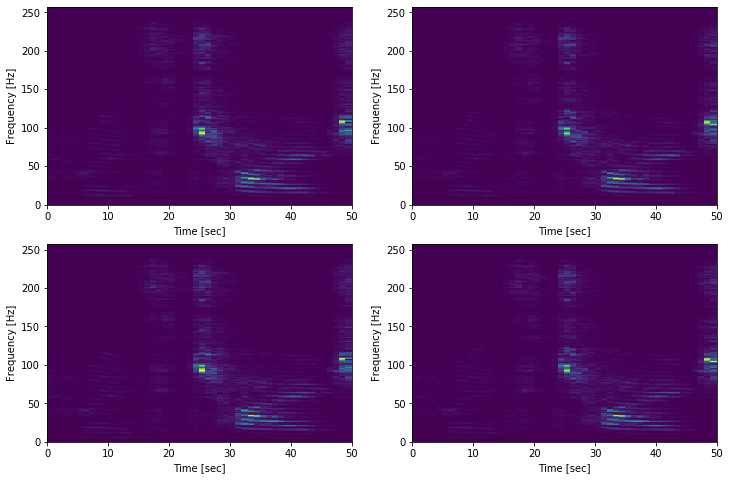

In [49]:
# calculate features
                        # speaker, file number, angle, time bins, frequency bins, channel

# clip dataset to just 1.4sec of data
fftWindowT_clipped = 50;
data_clipped = data[:,:,:,100:100+fftWindowT_clipped,:,:]
# show dimensions
print (np.shape(data)) 

# visualize features
plt.figure(figsize=(12, 8))
plt.subplot (221)
plot_data = data_clipped[0,1131,0,:,:,0]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (222)
plot_data = data_clipped[0,1131,0,:,:,1]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# prepare features for neural network
X = np.reshape(data_clipped, (angleN * filesN * speakerTypeN, fftWindowT_clipped, fftWindowN, micN))

plt.subplot (223)
plot_data = X[9048,:,:,0]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (224)
plot_data = X[9048,:,:,1]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# get meta data
deg = np.linspace(0, 315, angleN)
deg = np.matlib.repmat(deg, 1, filesN  * speakerTypeN).transpose()
#dist = np.full((filesN * angleN * speakerTypeN, 1), 1)

# prepare lables for neural network
#Y = np.vstack((deg.T, dist.T)).T
Y = deg#/360
print (np.shape(Y)) # speaker-angle-file number, angle, distance
print (np.shape(X)) # speaker-angle-file number, time bins, frequency bins, channel



In [50]:
print (np.max(X))
print (np.min(X))

XFFTSmall = X[:,:,0:257:4,:]
if singleMic:
    XFFTSmall = XFFTSmall[:,:,:,[0]]

X_train, X_validate, Y_train, Y_validate = train_test_split(XFFTSmall, Y, test_size = 0.2, random_state = 2)

Y_train = Y_train/45
Y_train = keras.utils.to_categorical (Y_train,8)
Y_validate = Y_validate/45
Y_validate = keras.utils.to_categorical (Y_validate,8)

print (np.shape(X_train))
print (np.shape(X_validate))
print (np.shape(Y_train))
print (np.shape(Y_validate))

# X_train = X_train.astype('float16')
# X_validate = X_validate.astype('float16')
# Y_train = Y_train.astype('float16')
# Y_validate = Y_validate.astype('float16')
print(X_train.shape[1:])
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

32767
0
(21734, 50, 65, 1)
(5434, 50, 65, 1)
(21734, 8)
(5434, 8)
(50, 65, 1)
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6839866019481080549
]


In [51]:
# Define batchsize and number of epochs
batchSize = 50
nEpochs = 30

#keras.backend.set_floatx('float16')

# Declare the sequential model and design your multi-layer perceptron
model = keras.models.Sequential()

model.add (keras.layers.InputLayer(input_shape=X_train.shape[1:]))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,4)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,4)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,2)))
model.add(keras.layers.Dropout(0.2))

#model.add(Reshape((4,fftWindowT_clipped)))
#model.add(Bidirectional(GRU(4,activation='tanh',return_sequences=True),merge_mode='mul'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Activation('softmax'))

# Compile your model
# model.compile(loss='mean_absolute_error',
#               optimizer='sgd',
#               metrics=['mae','mse'])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train your model
model.fit(X_train, Y_train, epochs = nEpochs , batch_size = batchSize)


Train on 21734 samples
Epoch 1/30
21734/21734 [==============================] - 69s 3ms/sample - loss: 2.0431 - accuracy: 0.2076
Epoch 2/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.8170 - accuracy: 0.2906
Epoch 3/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.6087 - accuracy: 0.3841
Epoch 4/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.5256 - accuracy: 0.4186
Epoch 5/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.4859 - accuracy: 0.4413
Epoch 6/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.4274 - accuracy: 0.4616
Epoch 7/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.3549 - accuracy: 0.4898
Epoch 8/30
21734/21734 [==============================] - 68s 3ms/sample - loss: 1.2728 - accuracy: 0.5191
Epoch 9/30
21734/21734 [==============================] - 69s 3ms/sample - loss: 1.2037 - accuracy: 0.5411
Epoch 10/30
21

In [59]:
model.build()
model.summary ()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 65, 4)         40        
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 65, 4)         16        
_________________________________________________________________
activation_4 (Activation)    (None, 50, 65, 4)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 16, 4)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 16, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 16, 4)         148       
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 16, 4)        

In [54]:
model.evaluate (X_validate,Y_validate)

5434/5434 [==============================] - 7s 1ms/sample - loss: 0.8297 - accuracy: 0.6947


[0.8297287308208899, 0.69470006]

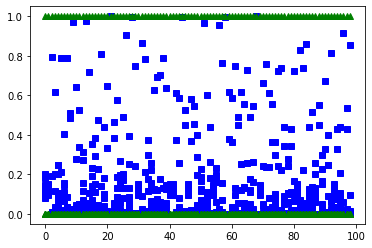

In [58]:
Y_pred = model.predict (X_validate)
index = 0
plt.plot (Y_pred[1:100,:],'bs',Y_validate[1:100,:],'g^')
plt.show()

In [56]:
model.evaluate (X_train,Y_train)

21734/21734 [==============================] - 26s 1ms/sample - loss: 0.8119 - accuracy: 0.6912


[0.8119090815920876, 0.6912211]

In [ ]:
Y_pred = model.predict (X_train)
index = 0
plt.plot (Y_pred,'bs',Y_train,'g^')
plt.show()

In [57]:
model.save ('classificationSmallTimeWithoutGRUSINGLEMIC.h5')

In [ ]:
model = models.load_model('classificationSmallTimeWithoutGRU.h5')

SyntaxError: invalid syntax (<ipython-input-12-cb235b7b1295>, line 1)

In [ ]:
print(np.max(data));


32767
